price: price in US dollars (\$326--\$18,823)

carat: weight of the diamond (0.2-5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)**

In [0]:
%matplotlib inline
!pip install ggplot
import pandas as pd
import numpy as np
from random import *
from sklearn.preprocessing import MinMaxScaler

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from ggplot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(style="white")
%matplotlib inline
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [0]:
diamonds_df = pd.read_csv("diamonds.csv");diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


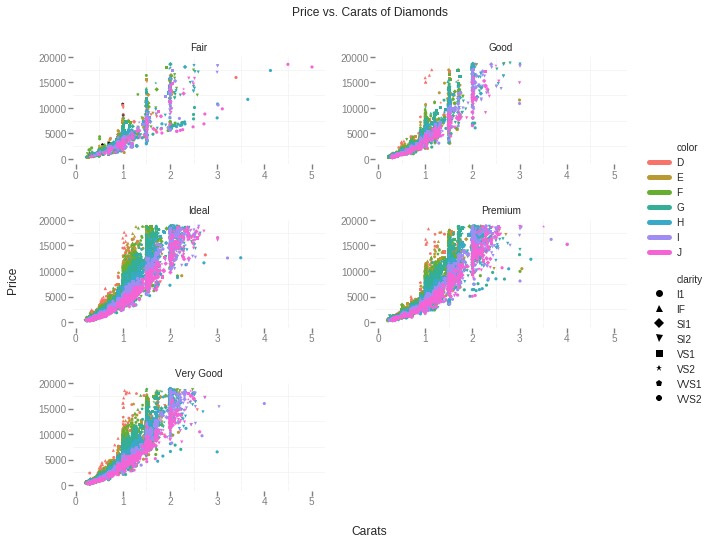

<ggplot: (8747605336177)>

In [0]:
ggplot(diamonds_df, aes(x='carat', y='price', color='color', shape='clarity')) +\
    geom_point(size=10) +\
    theme_bw() +\
    facet_wrap("cut") +\
    xlab("Carats") +\
    ylab("Price") +\
    ggtitle("Price vs. Carats of Diamonds")

j color best...  higher price, greater carat are for better quality diamonds.

From the heatmap, price has very high positive correlation with carat, x, y and z (dimensions). Other variables like table have moderate correlation. The categorical variables do not correlate well with price. So, carat, table, x, y and z could be our explanatory variables. However, since x, y and z are also highly correlated with carat, we need to remove some of them to tackle multicollinearity issues. Hence, we are left only with carat and table.

In [0]:
print("Number of rows with x == 0: {} ".format((diamonds_df.x==0).sum()))
print("Number of rows with y == 0: {} ".format((diamonds_df.y==0).sum()))
print("Number of rows with z == 0: {} ".format((diamonds_df.z==0).sum()))
print("Number of rows with depth == 0: {} ".format((diamonds_df.depth==0).sum()))

Number of rows with x == 0: 8 
Number of rows with y == 0: 7 
Number of rows with z == 0: 20 
Number of rows with depth == 0: 0 


In [0]:
diamonds_df[['x','y','z']] = diamonds_df[['x','y','z']].replace(0,np.NaN)

In [0]:
diamonds_df.isnull().sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           8
y           7
z          20
dtype: int64

In [0]:
diamonds_df.dropna(inplace=True)

In [0]:
d =  pd.get_dummies(diamonds_df)
d.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
numericals =  pd.DataFrame(sc_X.fit_transform(d[['carat','depth','x','y','z','table']]),columns=['carat','depth','x','y','z','table'],index=d.index)

In [0]:
numericals.head()

,carat,depth,x,y,z,table
0,-1.198204,-0.174203,-1.591573,-1.539219,-1.580084,-1.099725
1,-1.240417,-1.361090,-1.645173,-1.662014,-1.750896,1.585988
2,-1.198204,-3.385781,-1.502241,-1.460280,-1.750896,3.376463
3,-1.071566,0.454149,-1.368242,-1.319943,-1.295396,0.243131
4,-1.029353,1.082501,-1.243176,-1.214690,-1.124583,0.243131


In [0]:
d[['carat','depth','x','y','z','table']] = numericals[['carat','depth','x','y','z','table']]

In [0]:
d.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198204,-0.174203,-1.099725,326,-1.591573,-1.539219,-1.580084,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-1.240417,-1.361090,1.585988,326,-1.645173,-1.662014,-1.750896,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,-1.198204,-3.385781,3.376463,327,-1.502241,-1.460280,-1.750896,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.071566,0.454149,0.243131,334,-1.368242,-1.319943,-1.295396,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.029353,1.082501,0.243131,335,-1.243176,-1.214690,-1.124583,0,1,0,...,0,1,0,0,0,1,0,0,0,0


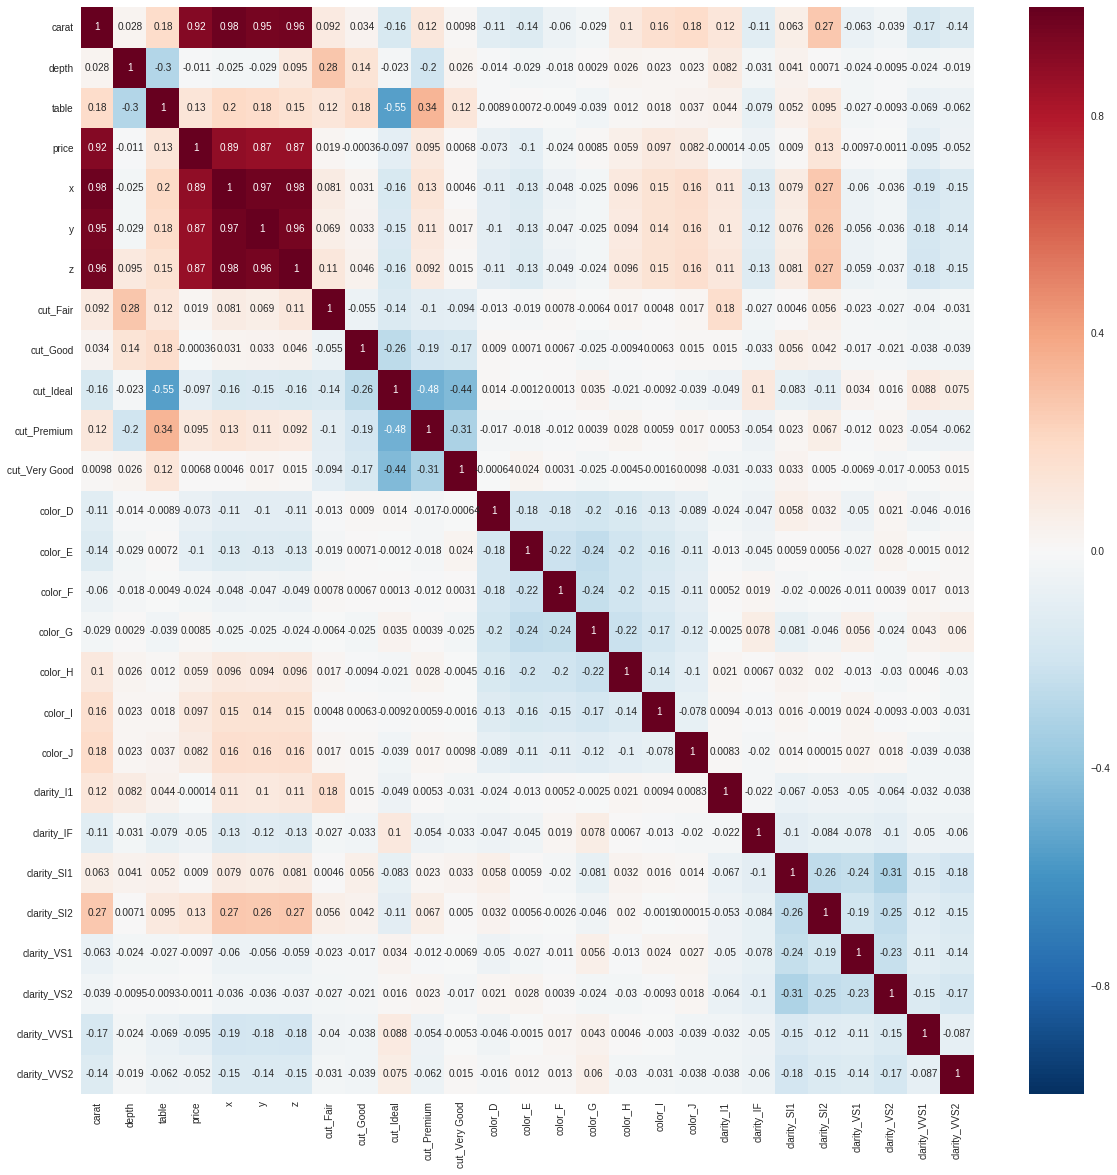

In [0]:
plt.figure(figsize=(20,20)) 
p=sns.heatmap(d.corr(), annot=True)

In [0]:
x = d.drop(["price"],axis=1)
y = d.price

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y,random_state = 2,test_size=0.3)

In [0]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(train_x,train_y)
y_pred = regr.predict(test_x)

In [0]:
from sklearn.metrics import mean_absolute_error
print("accuracy: "+ str(regr.score(test_x,test_y)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(test_y,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(test_y,y_pred)))
print('Coefficients: \n', regr.coef_)

accuracy: 92.21053491854796%
Mean absolute error: 731.7052423343224
Mean squared error: 1222240.4931998022
Coefficients: 
 [ 5.39627064e+03 -8.26548747e+01 -5.44805331e+01 -1.18432497e+03
  1.45789326e+01 -6.08907976e+01 -6.54167708e+14 -6.54167708e+14
 -6.54167708e+14 -6.54167708e+14 -6.54167708e+14  6.25043784e+15
  6.25043784e+15  6.25043784e+15  6.25043784e+15  6.25043784e+15
  6.25043784e+15  6.25043784e+15  3.13897121e+15  3.13897121e+15
  3.13897121e+15  3.13897121e+15  3.13897121e+15  3.13897121e+15
  3.13897121e+15  3.13897121e+15]
